In [ ]:
Step 1 - Importing required Libraries

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

In [2]:
warnings.filterwarnings("ignore")

In [ ]:
Step-2 import files from our drive

In [3]:
data_path = '/content/drive/MyDrive/trash_images'

In [8]:
# folders name
import os
print(os.listdir(data_path))

['metal', 'cardboard', 'plastic', 'paper', 'trash', 'glass']


In [9]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Counting number of images in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
trash_images,0
metal,410
cardboard,403
plastic,482
paper,596
trash,137
glass,501


In [10]:
print(f'Total {count.sum()}')

Total File Count    2529
dtype: int64


In [11]:
# Showing five images of each folder
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

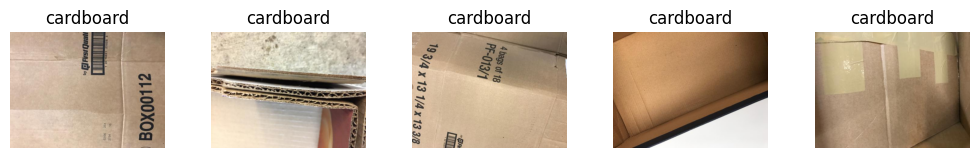

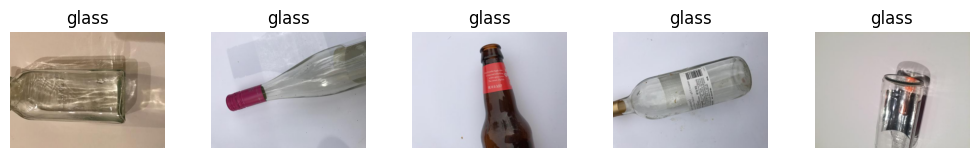

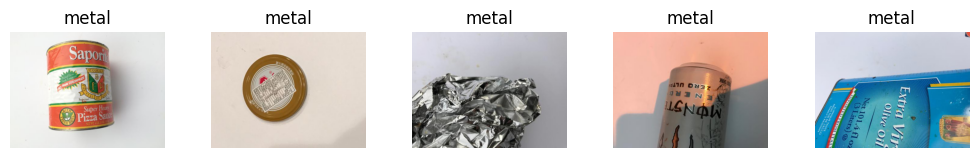

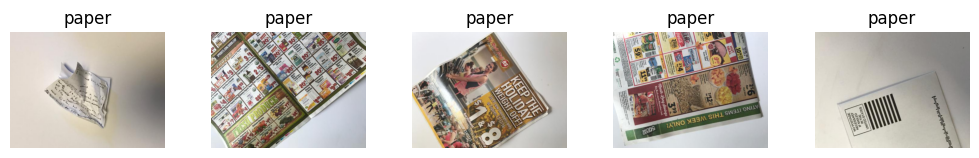

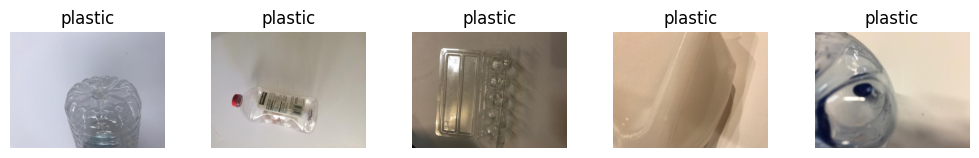

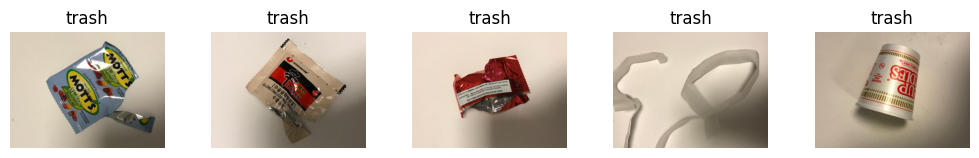

In [12]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

In [ ]:
Step -3 Preprcessing the data 

In [13]:
# Define variable for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

In [14]:
# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

In [ ]:
Step-4 Spliting test and train data

In [15]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2152 images belonging to 6 classes.


In [16]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


In [ ]:
Step-5 model and layers implementing

In [17]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

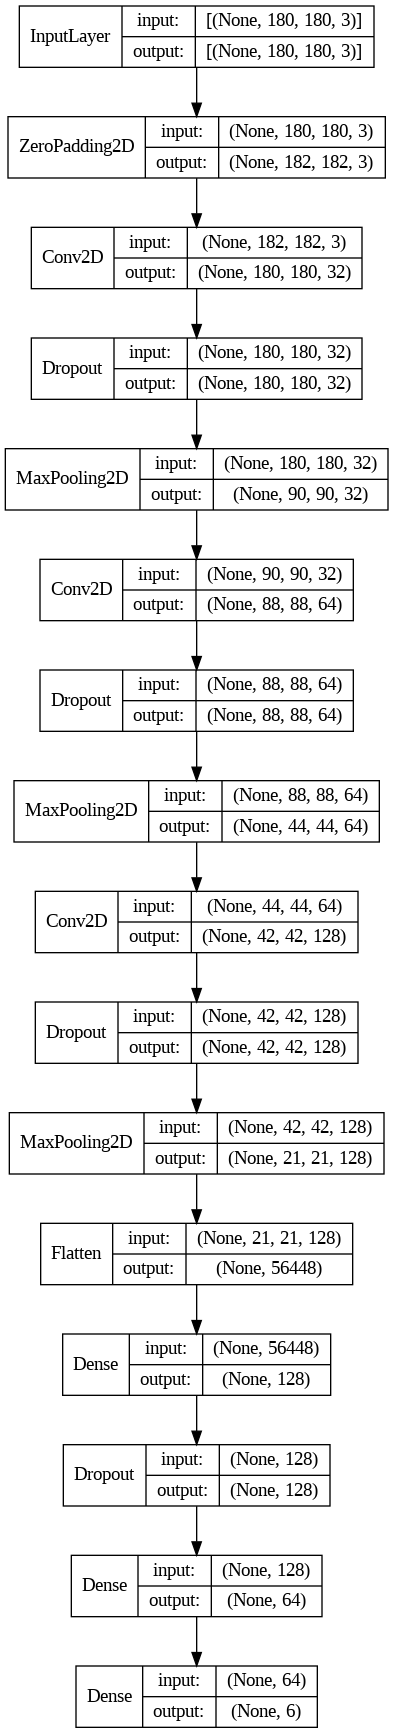

In [18]:
plot_model(model, show_shapes=True, show_layer_names=False)


In [ ]:
Step-6 compiling

In [19]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [20]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [21]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
Step-7 Model Training

In [24]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=10,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/10
72/72 [==============================] - 373s 5s/step - loss: 1.8506 - categorical_accuracy: 0.1993 - val_loss: 1.7572 - val_categorical_accuracy: 0.2785 - lr: 0.0010
Epoch 2/10
72/72 [==============================] - 223s 3s/step - loss: 1.6826 - categorical_accuracy: 0.2681 - val_loss: 1.5602 - val_categorical_accuracy: 0.3979 - lr: 0.0010
Epoch 3/10
72/72 [==============================] - 230s 3s/step - loss: 1.5954 - categorical_accuracy: 0.3276 - val_loss: 1.6176 - val_categorical_accuracy: 0.3687 - lr: 0.0010
Epoch 4/10
72/72 [==============================] - 225s 3s/step - loss: 1.5208 - categorical_accuracy: 0.3699 - val_loss: 1.5000 - val_categorical_accuracy: 0.4058 - lr: 0.0010
Epoch 5/10
72/72 [==============================] - 221s 3s/step - loss: 1.4574 - categorical_accuracy: 0.4061 - val_loss: 1.4751 - val_categorical_accuracy: 0.4695 - lr: 0.0010
Epoch 6/10
72/72 [==============================] - 224s 3s/step - loss: 1.4416 - categorical_accuracy: 0.4238

In [ ]:
Step-8 Model Evaluation

In [25]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.5358090400695801


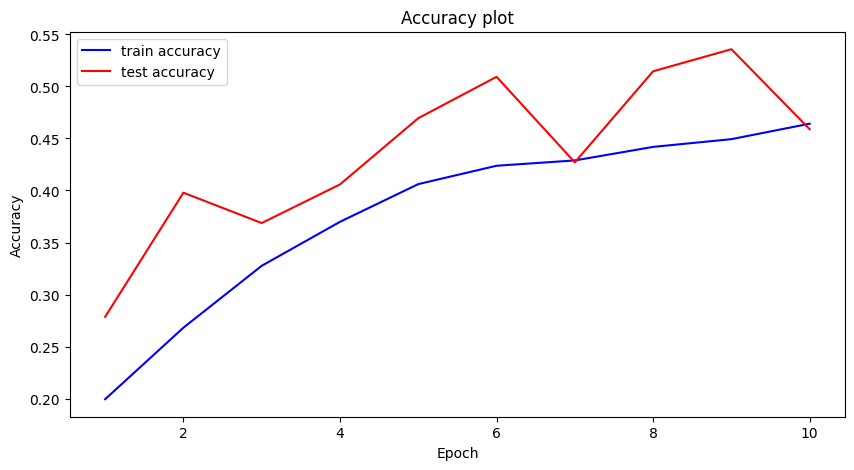

In [26]:
# Accuracy on train data :
accuracy = history.history['categorical_accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

In [ ]:
Step-9 using the model to check

In [27]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

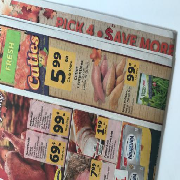

In [29]:
img = utils.load_img(
    '/content/drive/MyDrive/trash_images/paper/paper_010.jpg',
    grayscale=False,
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [30]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 [==============================] - 1s 610ms/step
paper
